## Problem Set 01
### AST 8110, Fall 2022
#### Tyler Barna

In [1]:
## Importing packages (some of these may not be useful)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import numba
import time
import sys
import os
import astropy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import random
from tqdm import tqdm
from numba import jit

## Set Seed
random.seed(8110)

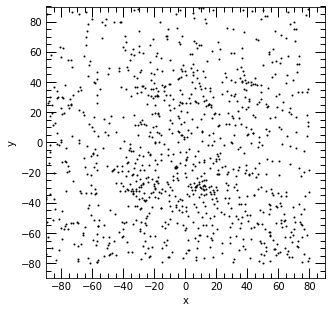

In [2]:
## read in data
data = np.loadtxt('pset1data.txt')


## plot data
def plot_data(dat=data):
    fig, ax = plt.figure(figsize=(5,5)), plt.gca()
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major',direction='in',top=True,right=True,length=10,width=1)
    ax.tick_params(axis='both', which='minor',direction='in',top=True,right=True, length=5,width=1)
    
    ax.plot(dat[:,0],dat[:,1],'.',markersize=2,color='black');
    plt.xlim(-90,90);
    plt.ylim(-90,90);
    plt.xlabel('x');
    plt.ylabel('y');
    return fig, ax
    
plot_data(dat=data);

In [3]:
## Generate Random galaxy positions
datSize = len(data)
galMultiplier = 10
def gen_galaxy_positions(N=datSize*galMultiplier,pkl=False,save=False):
    """
    Generates N random galaxy positions
    """
    if pkl and os.path.isfile(pkl):
        data = pd.read_pickle(pkl)
        return data
    else:
        x = np.random.uniform(-90,80,N)
        y = np.random.uniform(-80,90,N)
        data = np.column_stack((x,y))
        if save:
            pd.to_pickle(data, save)
        return data


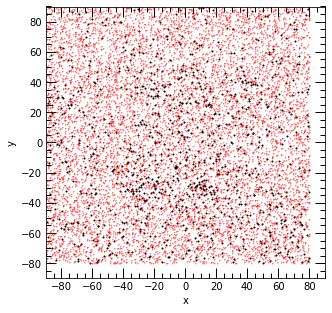

In [4]:
## import random galaxy positions previously generated and plot them
randData = gen_galaxy_positions()
fig, ax = plot_data(dat=data);
ax.plot(randData[:,0],randData[:,1],'+',markersize=1,color='red',alpha=0.5);

In [5]:
## calculate distances to other points
def get_dist(mode='dd',pkl=False,save=False):
    if pkl and os.path.isfile(pkl):
        dist = pd.read_pickle(pkl)
        return dist
    elif mode == 'dd':
        d1 = data 
        d2 = data
    elif mode =='rr':
        d1 = randData
        d2 = randData
    elif mode == 'dr':
        d1 = data
        d2 = randData
    
    dist = np.linalg.norm(d1-d2[:,None],axis=-1) ## calculates distances between all points in d1 and d2 (issue: double counts the distances if in dd or rr. Solved by only taking the upper triangle of the matrix)

    if mode == 'dd' or mode == 'rr': ## only take upper triangle of matrix to prevent double counting
        offset = 1 ## offset to remove self distances in dd and rr (i.e. distance between a point and itself)
        slice_idx = np.triu_indices_from(dist,k=offset) ## get indices for upper triangle of matrix
        #print(slice_idx)
        dist = dist[slice_idx] ## get upper triangle of matrix using indices
    elif mode == 'dr':
        dist = dist.flatten()
    if save:
        pd.to_pickle(dist, save)
    
    return dist

In [6]:
## calculate distances
dd = get_dist('dd')
rr = get_dist('rr')
dr = get_dist('dr')

In [7]:
max(dd), max(rr), max(dr)

(234.57367512361654, 238.5528490839443, 237.42252498728135)

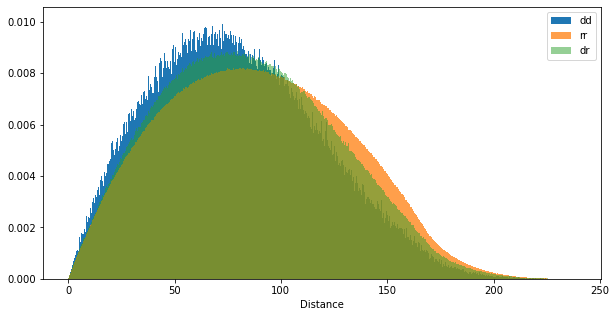

In [8]:
## plot histograms of distances
fig, ax = plt.figure(figsize=(10,5)), plt.gca()
plt.hist(dd,bins=1000,density=True,alpha=1,label='dd');
plt.hist(rr,bins=1000,density=True, alpha=0.75,label='rr');
plt.hist(dr,bins=1000,density=True, alpha=0.5,label='dr');
plt.legend();
plt.xlabel('Distance');

In [21]:
## develop correlation function
maxBin = 240
binWidth = 2
binArray = np.linspace(binWidth,maxBin,int(maxBin/binWidth)) ## the bins to use for the correlation function (bins are 5 length units)

## calculate bin averages
def get_bin_averages(dataset,binWidth=binWidth,pkl=False,save=False):
    # startBin = binWidth*round(min(dataset)/binWidth)
    # endBin = binWidth*round(max(dataset)/binWidth)
    # bin = np.arange(startBin,endBin,binWidth)
    #print('Bin Array:',bin)
    start_time = time.time()
    bin = binArray
    if pkl and os.path.isfile(pkl):
        binAvgs = pd.read_pickle(pkl)
        return bin, binAvgs
    idx = np.digitize(dataset,bin) ## get indices for each bin (digitize is a fast method to organize data into bins)
    print(idx)
    binAvgs = np.array([dataset[i].mean() for i in idx]); ## get the average of each bin
    if save:
        pd.to_pickle(binAvgs, save)
    print("--- %s seconds ---" % (time.time() - start_time))
    return bin, binAvgs

dd_bin, dd_avg = get_bin_averages(dd, pkl='dd_avg.pkl',save='dd_avg.pkl')
rr_bin, rr_avg = get_bin_averages(rr, pkl='rr_avg.pkl',save='rr_avg.pkl')
dr_bin, dr_avg = get_bin_averages(dr, pkl='dr_avg.pkl',save='dr_avg.pkl')
two_dr_bin, two_dr_avg = get_bin_averages(dr*2, pkl='2dr_avg.pkl',save='2dr_avg.pkl') ## this one confuses me somewhat

[69 30 47 ... 80 53 31]
--- 1.9943757057189941 seconds ---
[34 43 23 ... 52 45 35]


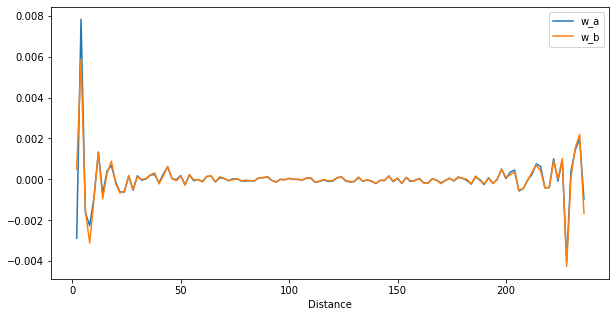

In [105]:
## calculate correlation function
w_a = [dd_i/rr_i -1 for dd_i,rr_i in zip(dd_avg,rr_avg)]
w_b = [dd_i/dr_i -1 for dd_i,dr_i in zip(dd_avg,dr_avg)]
#w_c = [(d_i - two_dr_i +rr_i)/(rr_i) for d_i,two_dr_i,rr_i in zip(dd_avg,two_dr_avg,rr_avg)] ## w_c seems to be too big

## plot correlation function
fig, ax = plt.figure(figsize=(10,5)), plt.gca()
plt.plot(dd_bin,w_a,label='w_a');
plt.plot(dd_bin,w_b,label='w_b');
#plt.plot(dd_bin,w_c,label='w_c');
plt.legend();
plt.xlabel('Distance');

In [106]:
dd_avg

array([  1.33250917,   3.13000758,   5.0561248 ,   7.02743368,
         9.026737  ,  11.0429563 ,  13.01280855,  15.02307267,
        17.02886715,  19.01313841,  21.00015776,  23.0004695 ,
        25.01391074,  26.99478285,  29.01347421,  31.00588378,
        33.00878939,  35.01537449,  37.01469579,  38.99867052,
        41.0158724 ,  43.0311981 ,  45.00529132,  47.00185117,
        49.01202243,  50.98893057,  53.01422842,  54.99999802,
        57.00258372,  58.99650224,  61.01160423,  63.01313275,
        64.99378968,  67.00691977,  69.00485568,  70.99633204,
        73.002576  ,  75.00280253,  76.99513514,  78.99405649,
        80.99453767,  82.99451818,  85.00623469,  87.00692635,
        89.0096349 ,  90.99486432,  92.98799939,  94.99879537,
        96.99685757,  99.00251317, 100.99803308, 102.99673467,
       104.99531687, 107.00387995, 109.00451429, 110.98242212,
       112.98630629, 114.99460273, 116.98531186, 118.98699241,
       121.00390738, 123.01176963, 124.9870567 , 126.97